#**HW 2: Optimize and train Deep Models**

In this homework, we will explore how to develop a simple Deep Neural Network for image classification. We will explore two common libraries: TensorFlow and Keras.
Then we will explore how to face a well know problem that is common to encounter during the training phase: the Overfitting.
Finally, we will study how to perform a fair model selection.
Hint: Before starting the exercise take a look at how Tensorflow and Keras are designed.  

##Exercise 2.1: Image Classficiation with Tensorflow and Keras

In this first exercise we will develop a 3 layer Neural Network to perfrom image classification.

Let's start importing the libraries we will need and setting a couple of environmental variables.


In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
from tensorflow import keras  # tf.keras
import time

#Set the log level in order to hide the unuseful warnings
import logging
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" 

tf.random.set_seed(42)

### Load Data: Fashion MNIST dataset

We will use the Fashion MNIST dataset, a dataset of Zalando's articles. Each sample is a 28x28 pixels grayscale image, associated with a label from 10 classes:

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

Each pixel intensity is represented by a uint8 (byte) from 0 to 255.
We will divide the dataset in training, testing and validation set. As you already know, the training set will be used to train the model, the validation set will be used to perform model selection and finally, the test set will be used to asses the performance of deep network.



In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = (
    fashion_mnist.load_data()) #The dataset is already divede in test and training...

#We extract the first 5000 samples of the training set, to use them as the validation set
X_valid, X_train = X_train_full[:5000], X_train_full[5000:] 
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

Let's take a look at a sample of the images in the dataset:

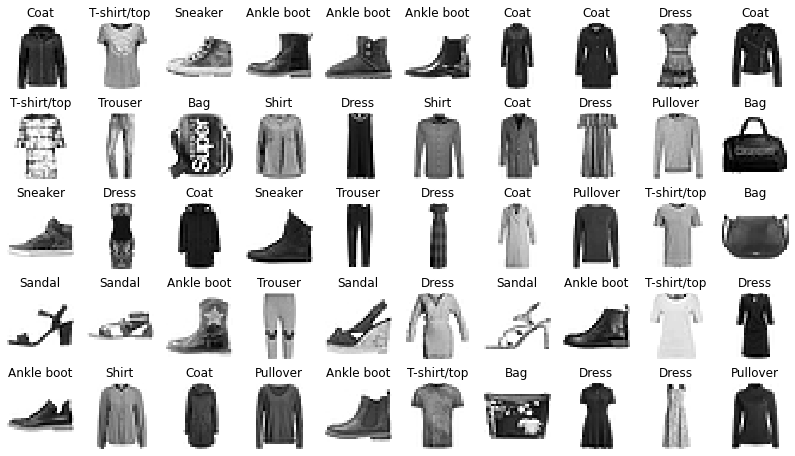

In [3]:
n_rows = 5
n_cols = 10
plt.figure(figsize=(n_cols*1.4, n_rows * 1.6))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]])
plt.show()

### Define the model:

Let's build a Sequential model (keras.models.Sequential) and add four layers to it by calling its add() method:


*  we start with a Flatten layer (keras.layers.Flatten) to convert each 28x28 image to a single row of 784 pixel values. Since it is the first layer in your model, you should specify the input_shape argument, leaving out the batch size: [28, 28];
*  a Dense layer (keras.layers.Dense) with 300 neurons, and the "relu" activation function;
* another Dense layer with 100 neurons, also with the "relu" activation function;
* a final Dense layer with 10 output neurons (one per class), and with the "softmax" activation function to ensure that the sum of all the estimated class probabilities for each image is equal to 1.

In [4]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

Call the model's summary() method to check if the model has been built correctly. Also, try using keras.utils.plot_model() to save an image of your model's architecture.

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [6]:
keras.utils.plot_model(model, "my_mnist_model.png", show_shapes=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


As you can see, the first dimension of each layer is not defined (?), indeed this dimension in each layer is variable and depends on the batch size.

### Optimize the model:

After the model has been created, you must call its compile() method to specify the loss function and the optimizer to use.

The conventional way is to have the target outputs to match the output shape. In this case that would mean to convert the targets to the one-hot encoded array to match with the output shape.
However, with the help of the sparse_categorical_crossentropy loss function, we can skip that step and keep the integers as targets.

 In this case, we want to use the "sparse_categorical_crossentropy" loss, and the SGD optimizer (stochastic gradient descent). 



Moreover, you can optionally specify a list of additional metrics that should be measured during training. In this case we specify metrics=["accuracy"].

In [7]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

Now our model is ready to be trained. Call its fit() method, passing to it the input features (X_train) and the target classes (y_train). Set the number of epoch to 20. 
In order to validate our model we will also pass the validation data by setting validation_data=(X_valid, y_valid). Keras will compute the loss and the additional metrics (the accuracy in this case) on the validation set at the end of each epoch. If the loss on the training set is much lower than the one on the validation set, your model is probably overfitting the training set. Note: the fit() method will return a History object containing training stats.

In [8]:
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 3s 54us/sample - loss: 2.6007 - accuracy: 0.6857 - val_loss: 0.7087 - val_accuracy: 0.7608
Epoch 2/20
55000/55000 [==============================] - 3s 47us/sample - loss: 0.6426 - accuracy: 0.7651 - val_loss: 0.6153 - val_accuracy: 0.7808
Epoch 3/20
55000/55000 [==============================] - 3s 51us/sample - loss: 0.5725 - accuracy: 0.7863 - val_loss: 0.5905 - val_accuracy: 0.7982
Epoch 4/20
55000/55000 [==============================] - 3s 50us/sample - loss: 0.5188 - accuracy: 0.8097 - val_loss: 0.6024 - val_accuracy: 0.8122
Epoch 5/20
55000/55000 [==============================] - 3s 49us/sample - loss: 0.4843 - accuracy: 0.8240 - val_loss: 0.5171 - val_accuracy: 0.8262
Epoch 6/20
55000/55000 [==============================] - 3s 51us/sample - loss: 0.4591 - accuracy: 0.8332 - val_loss: 0.5128 - val_accuracy: 0.8312
Epoch 7/20
55000/55000 [==============================] -

Let's plot the loss and the accuracy trends on both training and validation sets. We define the "plot_learning_curves" because we will reuse it in the next steps.

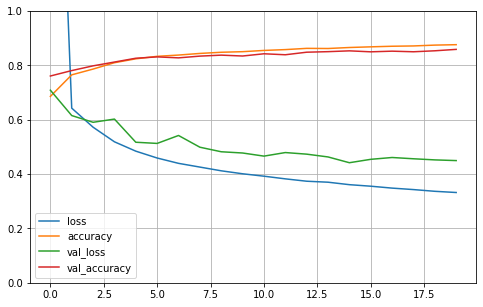

In [9]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
plot_learning_curves(history)

### Evaluate the model:

Now, our model has been optimized on the training set, and as you can see the performance on the validation set in quite similar (so it does not overfit the training data). Let's now evaluate the performance of our model using the test set.

In [10]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 0s 26us/sample - loss: 0.4728 - accuracy: 0.8423


[0.4727693128824234, 0.8423]

### Input normalization:

When using Gradient Descent, it is usually a good idea to ensure that all the features have a similar scale. It's a common practice to scale your data inputs to have zero mean and unit variance. This is known as the standard scaler approach.
Try to standardize the pixel values and see if this improves the performance of your neural network.

In [11]:
#To complete: define X_train_scaled, X_valid_scaled and X_test_scaled, the sets 
#that contain the normalized inputs.
#Hint: For each feature (pixel intensity), you must subtract the mean() of that 
#feature (across all instances, so use axis=0) and divide by its standard 
#deviation (std(), again axis=0)

mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train_scaled = (X_train - mean) / std
X_valid_scaled = (X_valid - mean) / std
X_test_scaled = (X_test - mean) / std

#Make sure you compute the means and standard deviations on the training set,
#and use these statistics to scale the training set, the validation set and the
# test set

#Alternatively, you can use Scikit-Learn's StandardScaler...

Let's define the model in order to re-initialize the weights and then train it by using the normalize data.

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 3s 56us/sample - loss: 0.9394 - accuracy: 0.6954 - val_loss: 0.6294 - val_accuracy: 0.7858
Epoch 2/20
55000/55000 [==============================] - 3s 48us/sample - loss: 0.5797 - accuracy: 0.7990 - val_loss: 0.5279 - val_accuracy: 0.8144
Epoch 3/20
55000/55000 [==============================] - 3s 48us/sample - loss: 0.5079 - accuracy: 0.8221 - val_loss: 0.4837 - val_accuracy: 0.8304
Epoch 4/20
55000/55000 [==============================] - 3s 48us/sample - loss: 0.4694 - accuracy: 0.8335 - val_loss: 0.4563 - val_accuracy: 0.8378
Epoch 5/20
55000/55000 [==============================] - 3s 49us/sample - loss: 0.4438 - accuracy: 0.8434 - val_loss: 0.4365 - val_accuracy: 0.8452
Epoch 6/20
55000/55000 [==============================] - 3s 51us/sample - loss: 0.4248 - accuracy: 0.8503 - val_loss: 0.4236 - val_accuracy: 0.8518
Epoch 7/20
55000/55000 [==============================] -

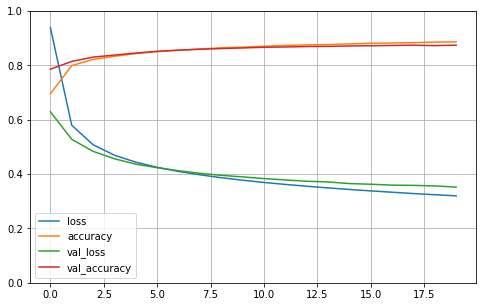

In [12]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

history = model.fit(X_train_scaled, y_train, epochs=20,
                    validation_data=(X_valid_scaled, y_valid))
print("Model Evaluation")
model.evaluate(X_test_scaled, y_test)
plot_learning_curves(history)

Note that the validation curve is smoother than in the previous test and it is also more simlar to the training curve.

## Exercise 2.2: Overfiting

A common problem that occurs when you train a deep neural network is overfittig. Overfitting occurs when you achieve a good fit of your model on the training data, while it does not generalize well on new, unseen data. In other words, the model learned patterns specific to the training data, which are irrelevant in other data.
As we have seen in the previous exercise, our model does not overfit the training data. In this exercise, we try to modify the training parameters in order to have a model that overfits.
Overfitting can have many causes and usually is a combination of some of them, for instance: too many parameters/ layers, too few training samples, wrong learning rate (usualy too high), etc..

In [13]:
#To complete: modify the previuos model in order to obtain  a new mdel that overfit the training data
#HINT: A model tends to overfit when too few training examples are available
X_train_small = X_train_scaled[:1000]
y_train_small = y_train[:1000]

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))

#To complete: Add layers
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
#HINT: A model tends to overfit  when the number of learnable parameters is very high compared to the number of training samples
#HINT: Is it possible to use different activation functions than ReLu

model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-2)) #To complete:learning rate

#HINT: A model tends to overfit when the number of training epochs is high
history = model.fit(X_train_small, y_train_small, epochs=150, #To complete: number of epochs
                    validation_data=(X_valid_scaled, y_valid))
print("Model Eval")
model.evaluate(X_test_scaled, y_test)

Train on 1000 samples, validate on 5000 samples
Epoch 1/150
1000/1000 [==============================] - 0s 403us/sample - loss: 1.7602 - val_loss: 1.1502
Epoch 2/150
1000/1000 [==============================] - 0s 195us/sample - loss: 0.9913 - val_loss: 0.8980
Epoch 3/150
1000/1000 [==============================] - 0s 192us/sample - loss: 0.7909 - val_loss: 0.8022
Epoch 4/150
1000/1000 [==============================] - 0s 191us/sample - loss: 0.6797 - val_loss: 0.7477
Epoch 5/150
1000/1000 [==============================] - 0s 192us/sample - loss: 0.6061 - val_loss: 0.6982
Epoch 6/150
1000/1000 [==============================] - 0s 190us/sample - loss: 0.5457 - val_loss: 0.6675
Epoch 7/150
1000/1000 [==============================] - 0s 192us/sample - loss: 0.4951 - val_loss: 0.6434
Epoch 8/150
1000/1000 [==============================] - 0s 190us/sample - loss: 0.4559 - val_loss: 0.6323
Epoch 9/150
1000/1000 [==============================] - 0s 192us/sample - loss: 0.4198 - val_lo

0.7721856475830078

Define the plot_learning_loss function and plot the loss and val_loss trends

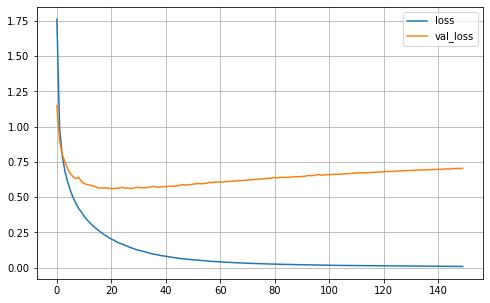

In [14]:
def plot_learning_loss(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.show()
plot_learning_loss(history)

### L1-norm

One possible way to solve the overitting issue is by using regularization methods. The two most common regularization methods in Deep Learning are the L1-norm regularization and the L2-norm regularization. Both These techniques are based on limiting the capacity of models, by adding a parameter norm penalty to the objective function $\mathcal{J}$:
$$
\hat{\mathcal{J}}(\theta,\mathbf{X},\mathbf{y}) = \mathcal{J}(\theta,\mathbf{X},\mathbf{y}) + \alpha \Omega(\theta)
$$
where $\alpha$ is a hyperparameter that weighs the relative contribution of the norm penalty $\Omega$.
Lets start by considering the L1-norm regularization where the regularization term is defined as:
$$
 \Omega(\theta)=||\mathbf{W}||_1=\sum_i |\mathbf{w}|
$$
Let's find the values for the $\alpha$ parameters that allow removing remove the overfitting effect.

Train on 1000 samples, validate on 5000 samples
Epoch 1/150
1000/1000 [==============================] - 1s 598us/sample - loss: 12.3984 - val_loss: 11.7791
Epoch 2/150
1000/1000 [==============================] - 0s 245us/sample - loss: 11.5897 - val_loss: 11.4658
Epoch 3/150
1000/1000 [==============================] - 0s 222us/sample - loss: 11.3112 - val_loss: 11.2897
Epoch 4/150
1000/1000 [==============================] - 0s 237us/sample - loss: 11.1240 - val_loss: 11.1626
Epoch 5/150
1000/1000 [==============================] - 0s 243us/sample - loss: 10.9768 - val_loss: 11.0439
Epoch 6/150
1000/1000 [==============================] - 0s 242us/sample - loss: 10.8425 - val_loss: 10.9236
Epoch 7/150
1000/1000 [==============================] - 0s 248us/sample - loss: 10.7164 - val_loss: 10.8248
Epoch 8/150
1000/1000 [==============================] - 0s 245us/sample - loss: 10.6011 - val_loss: 10.7387
Epoch 9/150
1000/1000 [==============================] - 0s 232us/sample - loss:

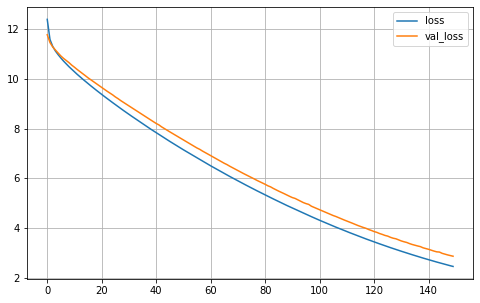

In [23]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))

#In Keras is neccesary to add the regularizer by using the attribute kernel_regularizer
#to each layer whose weights will be considered in the Omega function.
#is it also possibile to consider the bias by using the attribute bias_regularizer 
#tf.keras.regularizers.l1(alpha) perfrom the L1-norm regularization
model.add(keras.layers.Dense(300, activation="relu", kernel_regularizer=tf.keras.regularizers.l1(1e-3), bias_regularizer=tf.keras.regularizers.l1(1e-3)))
model.add(keras.layers.Dense(100, activation="relu", kernel_regularizer=tf.keras.regularizers.l1(1e-3), bias_regularizer=tf.keras.regularizers.l1(1e-3)))
#To , bias_regularizer=tf.keras.regularizers.l1(1e-4)complete: insert the model that you previously define that overfit the 
#trainnig data, and add the L1-norm regularization. Use the proper value for the
#alpha hyper-parameter, that prevents the model from overfitting. In general, a
#layer that exploits L1-norm regularization is defined as follow:

#model.add(keras.layers.Dense(units=To_complete, activation=To_complete,kernel_regularizer=tf.keras.regularizers.l1(To_complete))) 

model.add(keras.layers.Dense(10, activation="softmax", kernel_regularizer=tf.keras.regularizers.l1(1e-3), bias_regularizer=tf.keras.regularizers.l1(1e-3)))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-2)) #To complete: l2arning rate

history = model.fit(X_train_small, y_train_small, epochs=150, #To complete: number of epochs
                    validation_data=(X_valid_scaled, y_valid))
print("Model Evaluation")
model.evaluate(X_test_scaled, y_test)
plot_learning_loss(history)

### L2-norm

L2-norm regularization is also known as weight decay. This strategy drives the weights closer to the origin by adding the regularization term omega which is defined as:
$$
 \Omega(\theta)=\frac{1}{2}||\mathbf{W}||_2^2
$$

Let's find the values for the $\alpha$ parameters that allow removing remove the overfitting effect with L2-norm.

Train on 1000 samples, validate on 5000 samples
Epoch 1/150
1000/1000 [==============================] - 1s 656us/sample - loss: 8.4046 - val_loss: 7.8247
Epoch 2/150
1000/1000 [==============================] - 0s 251us/sample - loss: 7.6181 - val_loss: 7.4730
Epoch 3/150
1000/1000 [==============================] - 0s 236us/sample - loss: 7.3171 - val_loss: 7.2599
Epoch 4/150
1000/1000 [==============================] - 0s 231us/sample - loss: 7.1048 - val_loss: 7.0975
Epoch 5/150
1000/1000 [==============================] - 0s 272us/sample - loss: 6.9358 - val_loss: 6.9455
Epoch 6/150
1000/1000 [==============================] - 0s 256us/sample - loss: 6.7838 - val_loss: 6.8170
Epoch 7/150
1000/1000 [==============================] - 0s 233us/sample - loss: 6.6461 - val_loss: 6.6974
Epoch 8/150
1000/1000 [==============================] - 0s 254us/sample - loss: 6.5219 - val_loss: 6.5981
Epoch 9/150
1000/1000 [==============================] - 0s 244us/sample - loss: 6.4041 - val_lo

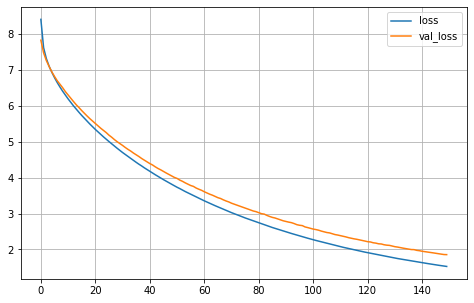

In [30]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))

#To complete: insert the model that you previously define that overfit the 
#trainnig data, and add the L2-norm regularization. Use the proper value for the
#alpha hyper-parameter, that prevents the model from overfitting. In general, a
#layer that exploits L2-norm regularization is defined as follow:
model.add(keras.layers.Dense(300, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(1e-2), bias_regularizer=tf.keras.regularizers.l2(1e-2)))
model.add(keras.layers.Dense(100, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(1e-2), bias_regularizer=tf.keras.regularizers.l2(1e-2)))
#model.add(keras.layers.Dense(units=To_complete, activation=To_complete,kernel_regularizer=tf.keras.regularizers.l2(To_complete))) 

model.add(keras.layers.Dense(10, activation="softmax",kernel_regularizer=tf.keras.regularizers.l2(5e-2), bias_regularizer=tf.keras.regularizers.l2(5e-2)))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-2)) #To complete: learning rate

history = model.fit(X_train_small, y_train_small, epochs=150, #To complete: that prevents the model from overfitting
                    validation_data=(X_valid_scaled, y_valid))
print("Model Evaluation")
model.evaluate(X_test_scaled, y_test)
plot_learning_loss(history)

### Early stopping

Early Stopping is a form of regularization used to avoid overfitting. It is designed to monitor the generalization error of one model and stop training when generalization error begins to degrade. In order to evaluate the generalization error, early stopping requires that a validation dataset is evaluated during training. Then, when the validation error does not improve for a specific number of epochs (patience hyper-parameter), it stops the training phase.

Train on 1000 samples, validate on 5000 samples
Epoch 1/150
1000/1000 [==============================] - 0s 483us/sample - loss: 1.7801 - val_loss: 1.2419
Epoch 2/150
1000/1000 [==============================] - 0s 272us/sample - loss: 1.0538 - val_loss: 0.9531
Epoch 3/150
1000/1000 [==============================] - 0s 265us/sample - loss: 0.8309 - val_loss: 0.8246
Epoch 4/150
1000/1000 [==============================] - 0s 262us/sample - loss: 0.7071 - val_loss: 0.7706
Epoch 5/150
1000/1000 [==============================] - 0s 236us/sample - loss: 0.6309 - val_loss: 0.7232
Epoch 6/150
1000/1000 [==============================] - 0s 286us/sample - loss: 0.5668 - val_loss: 0.6752
Epoch 7/150
1000/1000 [==============================] - 0s 281us/sample - loss: 0.5129 - val_loss: 0.6513
Epoch 8/150
1000/1000 [==============================] - 0s 238us/sample - loss: 0.4730 - val_loss: 0.6440
Epoch 9/150
1000/1000 [==============================] - 0s 250us/sample - loss: 0.4363 - val_lo

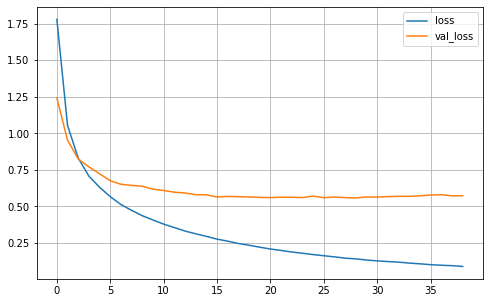

In [33]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))
#To complete: insert the model that you previously define that overfit the 
#trainnig data

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-2))  #To complete: learning rate

#Let's define a log dir in order to save the checkpoint file
logdir = os.path.join(os.curdir, "my_logs", "run_{}".format(time.time()))

#In Keras the Eraly stopping is manage by using the callbacks argument.
callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.EarlyStopping(patience=10), #To complete: play with patience and find the value that prevents the model from overfitting
    #Saving the checkpoints file allows to load the "best" model when the Early 
    #stopping detect that the generalization error degrade (after 'patience' epochs)
    keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True),
]

history = model.fit(X_train_small, y_train_small, epochs=150, #To complete: number of epochs
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=callbacks)

print("Model Evaluation")
#The early stopping stopped training after few epochs without progress, so your
#model may already have started to overfit the training set. Since the 
#ModelCheckpoint callback only saved the best models (on the validation set) the
#last saved model is the best on the validation set.
model = keras.models.load_model("my_mnist_model.h5")
model.evaluate(X_test_scaled, y_test)
plot_learning_loss(history)

## Exercise 2.3: Model Selection

Hyperparameters are the parameters of the learning method itself which we have to specify a priori, i.e., before model fitting. In contrast, model parameters are parameters which arise as a result of the fit. The aim of the model selection is selecting the best hyperparameters for our deep network. Finding the right hyperparameters for a model can be crucial for the model performance on given data. For istance lets consider our model trained by using different values for the learnign rate: 

In [37]:
learning_rates = [1e-4, 1e-2, 1e-1]

In [38]:
histories = []
for learning_rate in learning_rates:
    model = keras.models.Sequential([
                                    keras.layers.Flatten(input_shape=[28, 28]),
                                    keras.layers.Dense(300, activation="relu"),
                                    keras.layers.Dense(10, activation="softmax")])

    model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=learning_rate),
              metrics=["accuracy"])
              
    callbacks = [keras.callbacks.EarlyStopping(patience=2)]

    history = model.fit(X_train_scaled, y_train,
                        validation_data=(X_valid_scaled, y_valid), epochs=10,
                        callbacks=callbacks)
    histories.append(history)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 3s 51us/sample - loss: 1.9113 - accuracy: 0.3955 - val_loss: 1.3012 - val_accuracy: 0.6038
Epoch 2/10
55000/55000 [==============================] - 3s 47us/sample - loss: 1.1316 - accuracy: 0.6370 - val_loss: 0.9940 - val_accuracy: 0.6804
Epoch 3/10
55000/55000 [==============================] - 2s 45us/sample - loss: 0.9370 - accuracy: 0.6857 - val_loss: 0.8676 - val_accuracy: 0.7116
Epoch 4/10
55000/55000 [==============================] - 3s 46us/sample - loss: 0.8406 - accuracy: 0.7142 - val_loss: 0.7946 - val_accuracy: 0.7316
Epoch 5/10
55000/55000 [==============================] - 3s 47us/sample - loss: 0.7801 - accuracy: 0.7329 - val_loss: 0.7456 - val_accuracy: 0.7482
Epoch 6/10
55000/55000 [==============================] - 3s 47us/sample - loss: 0.7373 - accuracy: 0.7473 - val_loss: 0.7095 - val_accuracy: 0.7594
Epoch 7/10
55000/55000 [==============================] -

Let's plot the results

Learning rate: 0.0001


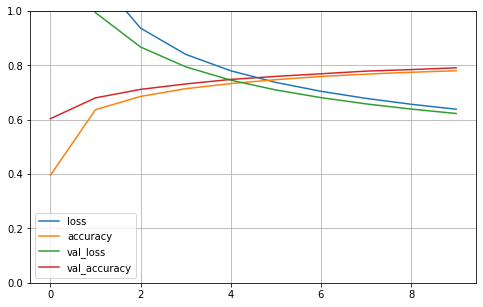

Learning rate: 0.01


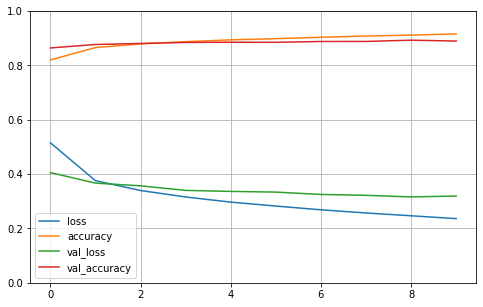

Learning rate: 0.1


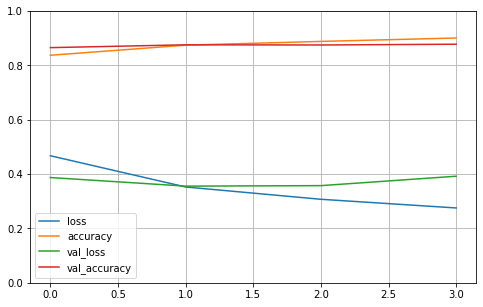

In [39]:
for learning_rate, history in zip(learning_rates, histories):
    print("Learning rate:", learning_rate)
    plot_learning_curves(history)

Note that the learning rate influence significantly the training phase. That behavior suggests that is crucial to validate the hyper-parameters to obtain good results.

### GRID Search:

Since a deep net has many hyperparameters, in order to find the best ones, we have to consider all the possible combinations of all of the possible values. One common method to perform this complex task is Grid-Search.
Given a set of values for each hyper-parameter, Grid-Search will build a model on each parameter combination possible. It iterates through every parameter combination and stores a model for each combination. Finally, the model that obtained the best result on the validation set will be select.

In order to perfrom Grid-Search we will use GridSearchCV method from scikit-learn.

Let's Create a build_model() function that takes two arguments, n_units and learning_rate, and builds, compiles and returns a model with the given number of of neurons and the given learning rate.
In order to limit the time demends of the proces we will consider only this two hyper-paramters and a small 3 layer model.

In [41]:
def build_model(n_units=30, learning_rate=1e-3):

  #To complete:
  #HINT: the function has to build the model with 3 layers:
  #- a Flatten layer to convert each 28x28 image to a single row 
  #- a Danse layer composed of n_units and that exploits Relu activation function 
  #- the output layer that uses the softmax activation function
  #Then, has to be defined how the model will be compiled.

  model = keras.models.Sequential([
                                    keras.layers.Flatten(input_shape=[28, 28]),
                                    keras.layers.Dense(n_units, activation="relu"),
                                    keras.layers.Dense(10, activation="softmax")])
  model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=learning_rate),
              metrics=["accuracy"])
    
  return model

    
#Create a keras.wrappers.scikit_learn.KerasRegressor and pass the build_model 
#function to the constructor. This gives you a Scikit-Learn compatible predictor
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

Let's define the lists of hyper-parameters' values. Also in this case, we use a very limited size lists, but in a real-world scenario a reasonable amount of possible values should be considered (try to add some values and check how much the time required to perform the Grid-Search increases)

In [43]:
param_distribs = {
    "n_units": [30, 300, 1000],# To_complete: insert a few (2 or 3) reasonable values  
    "learning_rate": [1e-2, 1e-3, 1e-4 ]}# To_complete: insert a few (2 or 3) reasonable values
    #Check how much increase the time required to perform GRID search increasing
    #the number of the values for each hyper-parameter.

Use a sklearn.model_selection.GridSearchCV to search the hyperparameter space of your KerasRegressor

In [44]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(keras_reg, param_distribs)

Run the Grid-Search

In [45]:
grid_search.fit(X_train_scaled, y_train, epochs=10, #The number of epochs can be modified (check what happens by increasing it) 
                  validation_data=(X_valid_scaled, y_valid))

0.9145 - accuracy: 0.6954 - val_loss: 0.8761 - val_accuracy: 0.7096
Epoch 9/10
44000/44000 [==============================] - 1s 33us/sample - loss: 0.8766 - accuracy: 0.7046 - val_loss: 0.8422 - val_accuracy: 0.7166
Epoch 10/10
11000/11000 [==============================] - 0s 24us/sample - loss: 0.8249 - accuracy: 0.7199
Train on 44000 samples, validate on 5000 samples
Epoch 1/10
44000/44000 [==============================] - 2s 37us/sample - loss: 2.1744 - accuracy: 0.2542 - val_loss: 1.7232 - val_accuracy: 0.4358
Epoch 2/10
44000/44000 [==============================] - 1s 33us/sample - loss: 1.5185 - accuracy: 0.5108 - val_loss: 1.3293 - val_accuracy: 0.5894
Epoch 3/10
44000/44000 [==============================] - 1s 32us/sample - loss: 1.2448 - accuracy: 0.6138 - val_loss: 1.1414 - val_accuracy: 0.6564
Epoch 4/10
44000/44000 [==============================] - 1s 33us/sample - loss: 1.0988 - accuracy: 0.6586 - val_loss: 1.0278 - val_accuracy: 0.6846
Epoch 5/10
44000/44000 [======

GridSearchCV(cv=None, error_score=nan,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x14d085450>,
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.01, 0.001, 0.0001],
                         'n_units': [30, 300, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Print the best hyper-parameters, and evealuate the best model on the test set.

In [46]:
print(grid_search.best_params_)

model = grid_search.best_estimator_.model
model.evaluate(X_test_scaled, y_test)

{'learning_rate': 0.01, 'n_units': 1000}
10000/10000 [==============================] - 1s 63us/sample - loss: 0.3367 - accuracy: 0.8829


[0.3367204336643219, 0.8829]